In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
pwd = "/content/drive/MyDrive/ECE661FinalProj_OODD"
os.chdir(pwd)

Mounted at /content/drive


In [2]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
def swish(x):
    return x/(1+torch.exp(-x))

In [58]:
# define the Resnet20 mode;
class Resnet20(nn.Module):
    def __init__(self):
        super(Resnet20, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batchnorm0 = nn.BatchNorm2d(16)
        
        self.conv1a = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1a = nn.BatchNorm2d(16)
        self.conv1b = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1b = nn.BatchNorm2d(16)
        self.conv1c = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1c = nn.BatchNorm2d(16)
        self.conv1d = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1d = nn.BatchNorm2d(16)
        self.conv1e = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1e = nn.BatchNorm2d(16)
        self.conv1f = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1f = nn.BatchNorm2d(16)
        
        self.conv1_2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.batchnorm1_2 = nn.BatchNorm2d(32)
        self.bypass1_2 = nn.Conv2d(16, 32, 1, stride=2)
        self.conv2a = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2a = nn.BatchNorm2d(32)
        self.conv2b = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2b = nn.BatchNorm2d(32)
        self.conv2c = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2c = nn.BatchNorm2d(32)
        self.conv2d = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2d = nn.BatchNorm2d(32)
        self.conv2e = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2e = nn.BatchNorm2d(32)
        
        self.conv2_3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.batchnorm2_3 = nn.BatchNorm2d(64)
        self.bypass2_3 = nn.Conv2d(32, 64, 1, stride=2)
        self.conv3a = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3a = nn.BatchNorm2d(64)
        self.conv3b = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3b = nn.BatchNorm2d(64)
        self.conv3c = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3c = nn.BatchNorm2d(64)
        self.conv3d = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3d = nn.BatchNorm2d(64)
        self.conv3e = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3e = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64, 5)

    def forward(self, x):
        # Inital convolution
        out = self.batchnorm0(self.conv0(x))
        out = bypass = swish(out)
        # Block 1   (condense block layers into functions)
            # Layer 1
        out = self.batchnorm1a(self.conv1a(out))
        out = swish(out)
        out = self.batchnorm1b(self.conv1b(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm1c(self.conv1c(out))
        out = swish(out)
        out = self.batchnorm1d(self.conv1d(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm1e(self.conv1e(out))
        out = swish(out)
        out = self.batchnorm1f(self.conv1f(out))
        out = bypass = swish(out + bypass)
        # Block 2
            # Layer 1
        bypass = self.bypass1_2(bypass)
        out = self.batchnorm1_2(self.conv1_2(out))
        out = swish(out)
        out = self.batchnorm2a(self.conv2a(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm2b(self.conv2b(out))
        out = swish(out)
        out = self.batchnorm2c(self.conv2c(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm2d(self.conv2d(out))
        out = swish(out)
        out = self.batchnorm2e(self.conv2e(out))
        out = bypass = swish(out + bypass)
        # Block 3
            # Layer 1
        bypass = self.bypass2_3(bypass)
        out = self.batchnorm2_3(self.conv2_3(out))
        out = swish(out)
        out = self.batchnorm3a(self.conv3a(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm3b(self.conv3b(out))
        out = swish(out)
        out = self.batchnorm3c(self.conv3c(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm3d(self.conv3d(out))
        out = swish(out)
        out = self.batchnorm3e(self.conv3e(out))
        out = bypass = swish(out + bypass)
        
        # Global Average Pool to go from 8x8 -> 1x1 feature maps
        out = F.avg_pool2d(out, 8)
        
        # Fully Connected Layer
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [59]:
# useful libraries
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10 as torchCIFAR10

#############################################
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)


# specify preprocessing function
transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std),
                                     transforms.RandomCrop(size=32, padding=4),
                                     transforms.RandomHorizontalFlip()])

transform_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])


#############################################

In [78]:
# a few arguments, do NOT change these
import numpy as np
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data import Subset

DATA_ROOT = "./data"
inTRAIN_BATCH_SIZE = 128
outBATCH_SIZE = 256
VAL_BATCH_SIZE = 100


# construct dataset
torch_train_set = torchCIFAR10(
    root=DATA_ROOT,
    train=True,
    transform=transform_train,
    download=True
)
all_testing = torchCIFAR10(
    root=DATA_ROOT,
    train=False,
    transform=transform_test,
    download=True
)

cifar5_train_labels = np.array(torch_train_set.targets)
cifar5_test_labels = np.array(all_testing.targets)
train_indices = []
all_test_indices = []
for i in [0,1,2,3,4]:
    train_indices += np.where(cifar5_train_labels == i)[0].tolist()
    all_test_indices += np.where(cifar5_test_labels == i)[0].tolist()

cifar5_train_set = Subset(torch_train_set, train_indices)
cifar5_test_set = Subset(all_testing, all_test_indices)

# construct dataloader
torch_train_loader = DataLoader(
    torch_train_set,
    batch_size = inTRAIN_BATCH_SIZE,
    shuffle = True
)

torch_test_loader = DataLoader(
    all_testing,
    batch_size = 100
)

cifar5_train_loader = DataLoader(
    cifar5_train_set,
    batch_size = inTRAIN_BATCH_SIZE,
    shuffle = True
)

cifar5_test_loader = DataLoader(
    cifar5_test_set,
    batch_size = VAL_BATCH_SIZE
)

from torchvision.datasets import CIFAR100

cifar100_set = CIFAR100(
    root=DATA_ROOT,
    train=False,
    transform=transform_test,
    download=True
)

cifar100_loader = DataLoader(
    cifar100_set,
    shuffle=True,
    batch_size = outBATCH_SIZE
)

cifar100_labels = np.array(cifar100_set.targets)
train_indices = []
test_indices = []

for i in range(50):
    train_indices += np.where(cifar100_labels == i)[0].tolist()

cifar50_set = Subset(cifar100_set, train_indices)

cifar50_loader = DataLoader(
    cifar50_set,
    shuffle=True,
    batch_size = outBATCH_SIZE
)

cifar20_indices = []
for i in range(20):
    cifar20_indices += np.where(cifar100_labels == i)[0].tolist()

cifar20_set = Subset(cifar100_set, cifar20_indices)

cifar20_loader = DataLoader(
    cifar20_set,
    shuffle=True,
    batch_size = outBATCH_SIZE
)

cifar5_indices = []
for i in range(5):
    cifar5_indices += np.where(cifar100_labels == i)[0].tolist()

cifar5_set = Subset(cifar100_set, cifar5_indices)

cifar5_loader = DataLoader(
    cifar5_set,
    shuffle=True,
    batch_size = outBATCH_SIZE
)

cifar1_indices = []
for i in range(1):
    cifar1_indices += np.where(cifar100_labels == i)[0].tolist()

cifar1_set = Subset(cifar100_set, cifar1_indices)

cifar1_loader = DataLoader(
    cifar1_set,
    shuffle=True,
    batch_size = outBATCH_SIZE
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#TRAINING

In [90]:
from torch.cuda.random import device_count
# specify the device for computation
#############################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = Resnet20()
cnn.to(device)
print(device)
#############################################

cuda:0


In [91]:
import torch.nn as nn
import torch.optim as optim

WARMUP_LR = .01
MOMENTUM = 0.9
REG = 5e-4
optimizer = optim.SGD(cnn.parameters(), lr=WARMUP_LR, momentum=MOMENTUM, weight_decay=REG)

EPOCHS = 150
CHECKPOINT_FOLDER = "./saved_model"

INITAL_LR = .1
DECAY_EPOCHS = 60
DECAY = .1

m_in = -23
m_out = -5

In [92]:
def train(in_loader, out_loader, PTH, energy=False):
    avg_loss = 0
    best_val_acc = 0
    current_learning_rate = WARMUP_LR
    #Learning rate scheduler
    for i in tqdm(range(EPOCHS)):
        if i == 5:
          current_learning_rate = INITAL_LR
        if i % DECAY_EPOCHS == 0 and i != 0:
          current_learning_rate = current_learning_rate * DECAY
          for param_group in optimizer.param_groups:
              param_group['lr'] = current_learning_rate
          
        cnn.train()
        
        print(f"Epoch: {i}/{EPOCHS}")
        for in_set, out_set in zip(in_loader, out_loader):
            
            data = torch.cat((in_set[0], out_set[0]), 0)
            target = in_set[1].type(torch.LongTensor)
            data, target = data.to(device), target.to(device)
            
            # Forward Pass
            x = cnn.forward(data)
            # print(x.shape)
            loss = F.cross_entropy(x[:len(in_set[0])], target)
            # cross-entropy from softmax distribution to uniform distribution
            if energy:
              Ec_out = -torch.logsumexp(x[len(in_set[0]):], dim=1)
              Ec_in = -torch.logsumexp(x[:len(in_set[0])], dim=1)
              loss += 0.1*(torch.pow(F.relu(Ec_in- m_in), 2).mean() + torch.pow(F.relu(m_out-Ec_out), 2).mean())

            else:
              loss += 0.5 * -(x[len(in_set[0]):].mean(1) - torch.logsumexp(x[len(in_set[0]):], dim=1)).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_loss = .8 * avg_loss + float(loss) * 0.2
      
        print(f"avg training loss: {avg_loss}")
      
        
        cnn.eval()

        total_examples = 0
        correct_examples = 0

        val_loss = 0

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(cifar5_test_loader):
              if batch_idx < 0.5*len(cifar5_test_loader):
                # copy inputs to device
                inputs = inputs.to(device)
                targets = targets.type(torch.LongTensor)
                targets = targets.to(device)

                # compute the output and loss
                output = cnn.forward(inputs)
                loss = F.cross_entropy(output, targets)
                val_loss += loss

                # count the number of correctly predicted samples in the current batch
                total_examples += targets.size()[0]
                batch_preds = torch.argmax(output, dim=1)
                correct_examples += (batch_preds == targets).int().sum().item()

        avg_loss = val_loss / (0.50* len(cifar5_test_loader))
        avg_acc = correct_examples / total_examples
        print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
        
        #save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
               os.makedirs(CHECKPOINT_FOLDER)
            print("Saving ...")
            state = {'state_dict': cnn.state_dict(),
                    'epoch': i,
                    'lr': current_learning_rate}
            torch.save(state, os.path.join(CHECKPOINT_FOLDER, PTH))


In [93]:
PTH = 'cifar5_cifar20_OE_resnet.pth'
in_loader = cifar5_train_loader
out_loader = cifar20_loader

train(in_loader, out_loader, PTH)

<ipython-input-92-eec71a9dc797>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(EPOCHS)):


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 0/150
avg training loss: 2.0040906467694093
Validation loss: 1.7000, Validation accuracy: 0.0000
Epoch: 1/150
avg training loss: 2.1908652782440186
Validation loss: 1.7812, Validation accuracy: 0.0000
Epoch: 2/150
avg training loss: 2.1241514682769775
Validation loss: 1.8532, Validation accuracy: 0.1420
Saving ...
Epoch: 3/150
avg training loss: 2.1117119789123535
Validation loss: 1.8275, Validation accuracy: 0.2456
Saving ...
Epoch: 4/150
avg training loss: 2.0383660793304443
Validation loss: 1.4956, Validation accuracy: 0.3700
Saving ...
Epoch: 5/150
avg training loss: 1.988984227180481
Validation loss: 1.1574, Validation accuracy: 0.5396
Saving ...
Epoch: 6/150
avg training loss: 1.8977431058883667
Validation loss: 0.8501, Validation accuracy: 0.6512
Saving ...
Epoch: 7/150
avg training loss: 1.874411702156067
Validation loss: 0.8695, Validation accuracy: 0.7060
Saving ...
Epoch: 8/150
avg training loss: 1.8183658123016357
Validation loss: 0.8919, Validation accuracy: 0.6420


In [83]:
state = {'state_dict': cnn.state_dict()}
torch.save(state, os.path.join(CHECKPOINT_FOLDER, PTH))

#TESTING

In [65]:
PTH = 'cifer5_cifar100_OE_resnet.pth'
cnn = Resnet20().to(device)
cnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, PTH))["state_dict"])
cnn.eval()

Resnet20(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1a): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1a): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1c): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1c): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1d): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1d): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1e): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1e): BatchNorm2d(16, eps=1e-

In [67]:
def energy_fun(cnn_output, T):
  return -T* torch.logsumexp(cnn_output / T, dim=1)

In [68]:
total_examples = 0
correct_examples = 0
val_loss = 0 
energy_corr_score = []
energy_fals_score = []

softmax_corr_score = []
softmax_fals_score = []

T = 1
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(cifar5_test_loader):
      if batch_idx > 0.50*len(cifar5_test_loader):
          # copy inputs to device
          inputs = inputs.to(device)
          targets = targets.type(torch.LongTensor)
          targets = targets.to(device)
          # compute the output and loss
          output = cnn.forward(inputs)
          softmax = F.softmax(output, dim=1)
          energy = energy_fun(output, T)

          # count the number of correctly predicted samples in the current batch
          total_examples += targets.size()[0]
          batch_preds = torch.argmax(output, dim=1)
          correct_mask = (batch_preds == targets)
          correct_examples += correct_mask.int().sum().item()
          soft_batch_preds = torch.argmax(softmax, dim=1)
          for i in range(len(correct_mask)):
              if correct_mask[i]:
                  energy_corr_score.append(energy[i].item())
                  softmax_corr_score.append(softmax[i][soft_batch_preds[i]].item())
              else:
                  energy_fals_score.append(energy[i].item())
                  softmax_fals_score.append(softmax[i][soft_batch_preds[i]].item())

print(correct_examples/total_examples)
energy_InD_score = energy_fals_score + energy_corr_score
softmax_InD_score = softmax_corr_score  + softmax_fals_score

0.76125


In [73]:
import numpy as np
# true positive here is defined as correctly classifying a prediction as erroneous
def plot_roc(false_softs, true_softs, title = "ROC Curve", show_95TPR = True, show_OPT = False):
    TPRs = []     #  true positive rates
    FPRs = []     # false positive rates
    AUROC = []    # will contain the AUROC approximation segments
    opt = {"thresh":-1, "diff":-1, "FPR":-1, "TPR":-1}
    FPR_at_TPR95 = -1
    closest_TPR_to95 = -1
    prev_FPR = 0
    ct95 = 1
    min_val = min(min(false_softs), min(true_softs))
    max_val = max(max(false_softs), max(true_softs))
    for i in tqdm(np.linspace(min_val, max_val, 1000)):
        FPR = sum(false_softs < i)/len(false_softs)
        TPR = sum(true_softs < i)/len(true_softs)
        AUROC.append((FPR-prev_FPR)*TPR)
        prev_FPR = FPR
        dis_from_95 = .95-TPR
        if abs(dis_from_95) < ct95:
            ct95 = dis_from_95
            FPR_at_TPR95 = FPR
            closest_TPR_to95 = TPR
        # if round(TPR,2) == .95:
        #     FPR_at_TPR95 = FPR
        TPRs.append(TPR)
        FPRs.append(FPR)
        if TPR-FPR > opt["diff"]:
            opt["thresh"], opt["diff"], opt["FPR"], opt["TPR"]  = i, TPR-FPR, FPR, TPR
    plt.plot(FPRs, TPRs, 'm')
    plt.plot([0,1], [0,1], "k--", linewidth=.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    if show_95TPR:
        plt.plot(FPR_at_TPR95, closest_TPR_to95, 'X', ms=11, label=f"FPR@95TPR: {round(FPR_at_TPR95,3)}")
    if show_OPT:
        plt.plot(opt["FPR"], opt["TPR"], 'X', ms=11, label=f"OPT Thresh: {round(opt['thresh'],3)}")
        print(opt)
    plt.legend()
    plt.show()
    print(f"AUROC: {sum(AUROC)}")

<ipython-input-28-4938b0975def>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.linspace(min_val, max_val, 1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

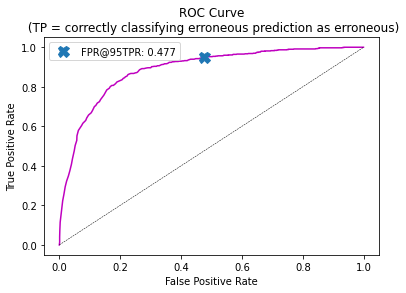

AUROC: 0.8872001175711451


In [30]:
plot_roc(softmax_corr_score, softmax_fals_score, title="ROC Curve\n (TP = correctly classifying erroneous prediction as erroneous)")

In [ ]:
from torchvision.datasets import CIFAR100

cifar100_set = CIFAR100(
    root=DATA_ROOT,
    train=False,
    transform=transform_test,
    download=True
)

cifar100_loader = DataLoader(
    cifar100_set
)

Files already downloaded and verified


In [69]:
def find_OOD_scores(OOD_loader):
  energy_OOD_score = []
  softmax_OOD_score = []
  with torch.no_grad():
      for i, (img, target) in tqdm(enumerate(OOD_loader)):
          img = img.to(device)
          target = target.type(torch.LongTensor)
          target = target.to(device)

          output = cnn.forward(img)
          # energy = energy_fun(output, T)
          softmax = F.softmax(output, dim=1)
          # print(softmax.shape)
          # print(energy.shape)
          # energy_OOD_score.append(energy.item())
          softmax_OOD_score.append(softmax[0][torch.argmax(softmax)].item())
          batch_pred = torch.argmax(output, dim=1)
  return softmax_OOD_score

In [48]:
softmax_OOD_score = find_OOD_scores(cifar100_loader)

<ipython-input-47-0d3cbe53d610>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (img, target) in tqdm(enumerate(OOD_loader)):


0it [00:00, ?it/s]

torch.Size([256, 10])


IndexError: ignored

In [74]:
plot_roc(softmax_OOD_score, softmax_InD_score)

NameError: ignored

In [70]:
from torchvision.datasets import SVHN

SVHN_Data = SVHN(
    root='./data/',
    transform=transform_test,
    download=True
)
SVHN_loader = DataLoader(
    SVHN_Data
)

Using downloaded and verified file: ./data/train_32x32.mat


In [71]:
svhnOOD_score = find_OOD_scores(SVHN_loader)

<ipython-input-69-bca9f90026e1>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (img, target) in tqdm(enumerate(OOD_loader)):


0it [00:00, ?it/s]

<ipython-input-73-4938b0975def>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.linspace(min_val, max_val, 1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

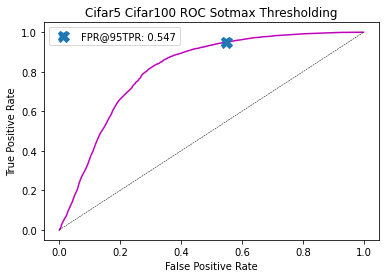

AUROC: 0.8151783617947768


In [75]:
plot_roc(softmax_InD_score,svhnOOD_score, title="Cifar5 Cifar100 ROC Sotmax Thresholding")